###### import required files and initial env

In [467]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
import warnings
import sys
import math
from imp import reload
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from livelossplot import PlotLosses

# A2 codes
import A2_codes.data_formater as A2_formater
import A2_codes.useritem_loader as A2_dataloader
import A2_codes.similarity_model as A2_SIM
import A2_codes.matrix_factoriz as A2_MF


warnings.filterwarnings('ignore')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device( "cpu")

# Movie Recommendation Models for Netflix Dataset

 Jingyi Wu 99151300

# Introduction


# Exploration

Netflix price dataset contains seven files include the ratings of users give to each movie with its date and the movie information include their publish date and name.  Since the initial format of dataset is not suitable for exploring, so my first step is to format it into tubule data for carry out subsequence of data mining and modelling works. 

In [3]:
df = pd.read_csv('./dataset/netflix-prize-data/combined_data_1.txt', 
                 header = None, names = ['user', 'rating','date'], 
                 usecols = [0,1,2])

In [138]:
movie_title_df = pd.read_csv('./dataset/netflix-prize-data/movie_titles.csv',
                             encoding = "ISO-8859-1",
                             header = None, names = ['movie','publish', 'title'], 
                             usecols = [0,1,2])

In [139]:
# the user id with empty rating and date is the movie id
df.head(5)

,user,rating,date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [140]:
movie_title_df.head(5)

,movie,publish,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [4]:
# slice movie by empty rows
sliced_df = A2_formater.slice_movie(df)

# format data type
sliced_df['date']= pd.to_datetime(sliced_df['date'])
sliced_df['rating']=sliced_df['rating'].astype(float)
sliced_df['movie']=sliced_df['movie'].astype(int)
sliced_df['user']=sliced_df['user'].astype(int)

In [6]:
movie_title_df['publish'][~(movie_title_df['publish'].isna())].mean()

In [ ]:
movie_title_df['movie']=movie_title_df['movie'].astype(int)
movie_title_df[movie_title_df['publish'].isna()] = movie_title_df['publish'][~(movie_title_df['publish'].isna())].mean() # fill missing
movie_title_df['publish']= pd.to_datetime(movie_title_df['publish'].astype(int), format ='%Y' )
combine_df = sliced_df.merge(movie_title_df[['publish','movie']],on='movie')
combine_df.head(5)

In [133]:
print("Data length: ",len(combine_df))

Data length:  24053764


After formatted dataset, we got 24053764 count of tabule data, and it contains five attributes: movie id, user id, rating of user give to movie, date of rating record, and movie publish year. 

------------------------
### user
- Type: Numeric categories

The id of users, after drop duplicates we can seen that dataset contains 470758 different users. most users are rated 10~50 movies, only few of them had rating over 2000 movies.

Length:  470758


{'whiskers': [<matplotlib.lines.Line2D at 0x2462b2ddeb8>,
 'caps': [<matplotlib.lines.Line2D at 0x2462b2e7588>,
 'boxes': [<matplotlib.lines.Line2D at 0x2462b2dda90>],
 'medians': [<matplotlib.lines.Line2D at 0x2462b2e7c18>],
 'fliers': [<matplotlib.lines.Line2D at 0x2462b2e7f60>],
 'means': []}

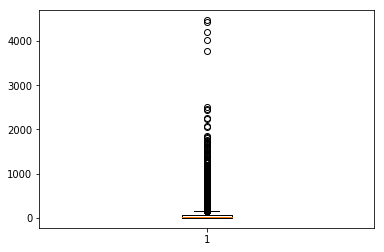

In [100]:
users_rating_count = sliced_df.groupby('user')['user'].agg(['count']).reset_index()
print("Length: ",len(users_rating_count))
plt.boxplot(users_rating_count['count'].astype(int))

         binned   count
0        (0, 1]   15225
1       (1, 10]  124902
2      (10, 50]  184967
3     (50, 100]   75394
4   (100, 1000]   70185
5  (1000, 2000]      73
6  (2000, 5000]      12


<BarContainer object of 7 artists>

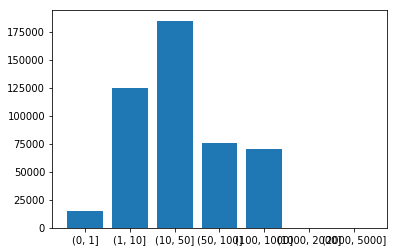

In [101]:
bins = [0,1,10,50,100,1000,2000,5000]
users_rating_count['binned'] = pd.cut(users_rating_count['count'], bins)
user_activity_bin = users_rating_count.groupby('binned')['binned'].agg(['count']).reset_index()
print(user_activity_bin)
plt.bar(user_activity_bin['binned'].astype(str),user_activity_bin['count'])

### movie
- Type: Numeric categories

The id of movie,  after drop duplicates we can seen that dataset contains 4499 different movie. And this id is formated in a complete ordered sequence from 1 to 4499.And most movies have limite rating records.

Number of moves:  4499
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


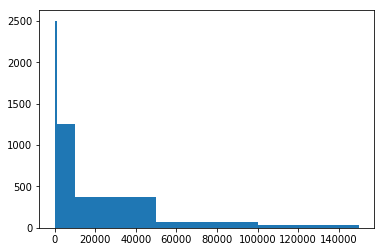

In [106]:
movie_popularity = sliced_df.groupby('movie')['movie'].agg(['count']).reset_index()
plt.hist(movie_popularity['count'],bins=[0,100,1000,10000,50000,100000,150000])
print("Number of moves: ",len(movie_popularity ))
print(list(movie_popularity['movie'][:100]))

### rating
- Type: Numeric ordinal
- Value range: 1,2,3,4,5

The rating of user give to the movie, most values are around 4, and only few values are rating one. 

In [79]:
print("rating min: ",sliced_df['rating'].min()," max: ",sliced_df['rating'].max()," mode: ", sliced_df['rating'].mode())

rating min:  1.0  max:  5.0  mode:  0    4.0
dtype: float64


   rating    count
0     1.0  1118186
1     2.0  2439073
2     3.0  6904181
3     4.0  8085741
4     5.0  5506583


<BarContainer object of 5 artists>

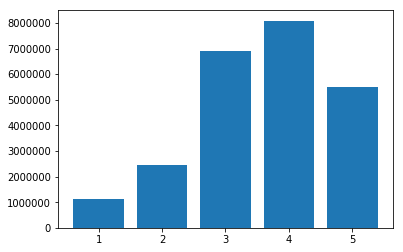

In [75]:
rating_distr = sliced_df.groupby('rating')['rating'].agg(['count']).reset_index()
print(rating_distr)
plt.bar(rating_distr["rating"],rating_distr["count"])

### date
- Type: Ordinal Date
- Value range: 1999-11-11 ~ 2005-12-31

The timestamp of the user rating the movie. along with the time progresses, the rating data have rapid growth

In [80]:
print("date min: ",sliced_df['date'].min()," max: ",sliced_df['date'].max())

date min:  1999-11-11 00:00:00  max:  2005-12-31 00:00:00


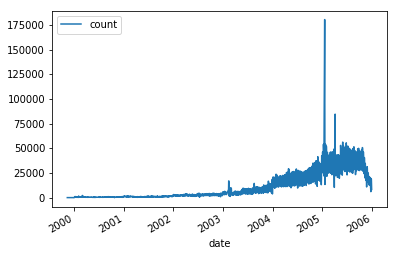

In [99]:
date_distr = sliced_df.groupby('date')['date'].agg(['count']).reset_index().set_index('date')
date_distr.plot()

### publish
- Type: Ordinal Date
- Value range: 1915-01-01 ~ 2005-01-01

The movie publish time, it shows most movies in dataset are close to the time of dataset published, and new movies rapidly increase by year.

In [148]:
print("publish min: ",combine_df.min()," max: ",combine_df['publish'].max())

publish min:  1915-01-01 00:00:00  max:  2005-01-01 00:00:00


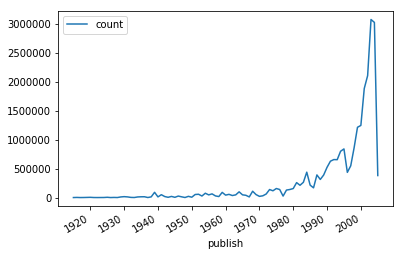

In [155]:
publish_distr = combine_df.groupby('publish')['publish'].agg(['count']).reset_index().set_index('publish')
publish_distr.plot()
plt.show()

### Sparse  matrix

Overall, the user-movie rating data is an matrix like `[user ,[movie ,[rating, ]]]`, each row of it is represents a user, each column represents a movie, and the each corresponding element is represent the rating of user give to movie. Since that sparse matrix have a very high dimension due to large number of users and movies, it brings the of challenge on memory cost.

In [ ]:
## imposible to put all data into memoty by one matrix
# full_data_sprase_matrix = A2_formater.make_sprase_matrix(sliced_df[:],4499) # Memory Error

In [201]:
## so, just use part of data for explore the sparsity and calculate full cost
sparse_matrix = A2_formater.make_sparse_matrix(sliced_df[:4499],4499)
memory_cost = sys.getsizeof(sparse_matrix)
full_memory_cost = memory_cost/4499*len(sliced_df)
def byte_to_mb(b):
    return b / 1024/1024
print(sparse_matrix)
print("memory cost for 4499 x 4499 sparse matrix: %d byte = %d mb"%(memory_cost,byte_to_mb(memory_cost)))
print("memory cost for full data sparse matrix: %d byte = %d mb"%(full_memory_cost,byte_to_mb(full_memory_cost)))

[[3. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
memory cost for 4499 x 4499 sparse matrix: 156889240 byte = 149 mb
memory cost for full data sparse matrix: 838803457012 byte = 799945 mb


while, althrough that matrix are very large, but due to the user is impossible to give all movie the rating, so the most location in that matrix are 0, which means its a sparse matrix,
by samples part of data for measure the sparsity of Netflix data, it shows 0.02% sparsity , which means 99.98% space in that matrix are 0.

In [202]:
sparsity = float(len(sprase_matrix.nonzero()[0]))
sparsity /= (sparse_matrix.shape[0] * sparse_matrix.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.02%


### Clean

Since the low activate users are useless for training model, I filtered the user have rated movies lower than 50. And for evaluate the models I will explain in next section, I decided to split the data set into three sets.

- Train: include most data except the data in test set.
- Test: randomly choose 1/10 users, and split their data by time '2005/12/1', so that dataset have include 1/10 users without data after '2005/12/1'.
- Target: target is the full data of test data, it include full data of 1/10 users chosen by test set

This split way allows me can evaluate the accuracy of model predict the rating of users would give to the items they were not seen before, at same time allows me can choose small or large amount of data to evaluate models.

In [54]:
users_df = A2_formater.get_users_df(sliced_df)

In [ ]:
# split data only by user id
# train_set, test_set = filter_data_by_user(sliced_df,users_df,frac=0.1,count=50)

In [ ]:
#split data by date and user id
train_set, test_set, target_set = A2_formater.filter_data_by_date(sliced_df,users_df)
target_set = target_set[target_set['user'].isin(test_set['user'])]

In [78]:
# makeup data
total_ratings,user_item_pairs,ratings,num_users,num_items,user_lists = A2_dataloader.prepro(train_set)
total_ratings_test,user_item_pairs_test,ratings_test = A2_dataloader.prepro(test_set,user_lists)
# make dataset 
train_dataset = A2_dataloader.UserItemDataset(user_item_pairs,ratings)
test_dataset = A2_dataloader.UserItemDataset(user_item_pairs_test,ratings_test)

num_users:  145643 num_items:  4499


In [92]:
# make data loader
sample_params = {'batch_size': 1024,'shuffle': True,'num_workers': 0}
train_generator = torch.utils.data.DataLoader(train_dataset, **sample_params)
test_generator = torch.utils.data.DataLoader(test_dataset, **sample_params)
train_iter = iter(train_generator)
test_iter = iter(test_generator)

# Methodology

The formal recommendation system have two main ways, one is content based system that use the   tags of items and historical preference of user to recommend the item have same tags as user browsed before, but those kind of system have the problem of over-specialization that can only find known preference while can't find potential preference, and easy to make other problem of information cocoon. (Adomavicius & Tuzhilin 2005) So, for solve the problem of information overload I think that collaborative filter based systems are more appropriated, those kind of methods make recommendation by sharing information between user or items, main idea of them are make recommendation by find other users have same preference.  in this case, I also identifier movie recommendation problem as a rating prediction problem, in this section I had built the models can predict the rating of user would give to item by input or modelling the existing user-movie data.

## Item-based and User-based Similarity Models
As the fundamental of the collaborative filtering methods, the item-based and user-based similarity models can be the good baseline when evaluate other models. those two are both the memory based collaborative filtering methods, they are measure the similarity of users and items by cosine, Pearson or other correlation coefficient matric to make a matrix record the similarity between users or items.

since the memory based model requires very large memory space, i only use 5156 users\' data for make similarity matrix. 

In [444]:
# use small amount of data to make matrix
# train_matrix = A2_formater.make_sparse_matrix(test_set,4499)
test_matrix = A2_formater.make_sparse_matrix(target_set,4499)
print("Train matrix:",train_matrix.shape)
print("Test matrix:",test_matrix.shape)

Train matrix: (5156, 4499)
Test matrix: (5156, 4499)


In [ ]:
def get_union(vector1,vector2):
    new_vector1 = vector1[(vector1!=0 )& (vector2 != 0)]
    new_vector2 = vector2[(vector1!=0 )& (vector2 != 0)]
    return new_vector1,new_vector2

Cosine Similarity: 

$W_{u, v}=\frac{|N(u) \cap N(v)|}{\sqrt{|N(u)||N(v)|}}$

In [ ]:
def cosine_similarity(vector1, vector2):
    new_vector1, new_vector2 = get_union(vector1,vector2)
    if len(new_vector1)==0 or len(new_vector2)==0:
        return 0
    dot_product = (new_vector1*new_vector2).sum()
    normA = ((new_vector1)**2).sum()
    normB = ((new_vector2)**2).sum()
    return round(dot_product / ((normA**0.5)*(normB**0.5)), 2)

Pearson Correlation Coefficient: 

$r=\frac{\sum_{i=1}^{n}\left(X_{i}-\overline{X}\right)\left(Y_{i}-\overline{Y}\right)}{\sqrt{\sum_{i=1}^{n}\left(X_{i}-\overline{X}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(Y_{i}-\overline{Y}\right)^{2}}}$

In [452]:
def pearson_similarity(vector1, vector2):
    new_vector1, new_vector2 = get_union(vector1,vector2)
    if len(new_vector1)==0 or len(new_vector2)==0:
        return 0
    new_vector1_mean = new_vector1 - np.mean(new_vector1)
    new_vector2_mean = new_vector2 - np.mean(new_vector2)
    norm = np.linalg.norm(new_vector1_mean)*np.linalg.norm(new_vector2_mean)
    return np.dot(new_vector1_mean,new_vector2_mean)/norm

In [453]:
def user_sim(train_data_matrix, algo = "cosine"):
    user_similarity = np.zeros((train_data_matrix.shape[0], train_data_matrix.shape[0]))
    for i, cur in enumerate(user_similarity):
        for j,v in enumerate(cur):
            if user_similarity[i][j] == 0:
                if algo == "cosine":
                    user_similarity[i][j] = cosine_similarity(train_data_matrix[i], train_data_matrix[j])
                else:
                    user_similarity[i][j] = pearson_similarity(train_data_matrix[i], train_data_matrix[j])
                user_similarity[j][i] = user_similarity[i][j]
    return user_similarity

def item_sim(train_data_matrix, algo = "cosine"):
    train_data_matrix_t = train_data_matrix.T
    item_similarity = np.zeros((train_data_matrix.shape[1], train_data_matrix.shape[1]))
    for i, cur in enumerate(item_similarity):
        for j,v in enumerate(cur):
            if item_similarity[i][j] == 0:
                if algo == "cosine":
                    item_similarity[i][j] = cosine_similarity(train_data_matrix_t[i], train_data_matrix_t[j])
                else:
                    item_similarity[i][j] = pearson_similarity(train_data_matrix_t[i], train_data_matrix_t[j])
                item_similarity[j][i] = item_similarity[i][j]
    return item_similarity

In [450]:
user_similarity = A2_SIM.user_sim(train_matrix)

1.0 0.0
(5156, 5156)
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [1. 1. 0. ... 0. 0. 1.]]


In [451]:
item_similarity = A2_SIM.item_sim(train_matrix)

1.0 0.0
(4499, 4499)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Matrix Factorization

In [471]:
class MF(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,h = 512):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.h = h

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim,sparse=True)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim,sparse=True)
        self.user_fc = nn.Linear(in_features=self.latent_dim, out_features=self.h, bias=True)
        self.item_fc = nn.Linear(in_features=self.latent_dim, out_features=self.h, bias=True)
    
        self.fc = nn.Linear(in_features=self.h, out_features=1, bias=True)
    
        
    def forward(self, user_indices, item_indices):
        user_embedding = F.relu(self.user_fc(self.embedding_user(user_indices)))
        item_embedding = F.relu(self.item_fc(self.embedding_item(item_indices)))
        
        return F.relu(self.fc(user_embedding * item_embedding))

In [329]:
class MLP(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,layers = [16,32,16,8]):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        self.affine_output = torch.nn.Linear(in_features=layers[-1], out_features=1)
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            
        out = self.affine_output(vector)
        return out


In [341]:
# Basic MF model
MF_model = MF(num_users+1,num_items+1).to(device)
MF_opt = optim.SGD(MF_model.parameters(), lr=0.001)
MF_criterion = torch.nn.MSELoss()

In [342]:
# MLP based model
MLP_model = MLP(num_users+1,num_items+1).to(device)
MLP_opt = optim.SGD(MLP_model.parameters(), lr=0.001)
MLP_criterion = torch.nn.MSELoss()

In [343]:
# eval data
testab = test_iter.next()

In [369]:
testab[0]

tensor([[ 19301,   3579,      0,  ...,      0,      0,      0],
        [ 99686,    528,      0,  ...,      0,      0,      0],
        [103430,   3451,      0,  ...,      0,      0,      0],
        ...,
        [ 15362,   2391,      0,  ...,      0,      0,      0],
        [100565,    872,      0,  ...,      0,      0,      0],
        [ 49296,   3860,      0,  ...,      0,      0,      0]],
       dtype=torch.int32)

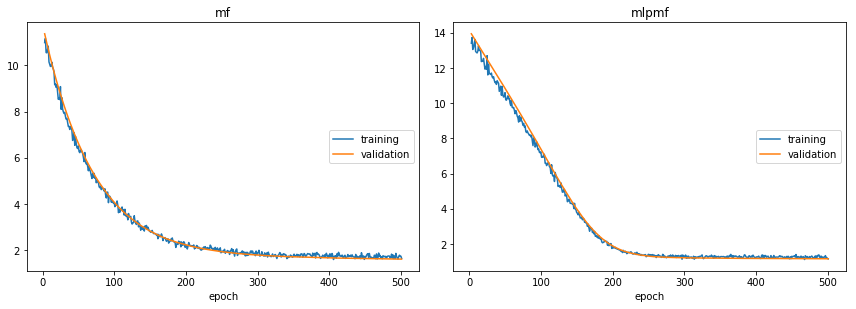

mf:
training   (min:    1.595, max:   11.169, cur:    1.647)
validation (min:    1.612, max:   11.645, cur:    1.612)

mlpmf:
training   (min:    1.120, max:   13.726, cur:    1.157)
validation (min:    1.164, max:   14.069, cur:    1.164)


In [348]:
liveloss = PlotLosses()
mftrain,mlptrain, = A2_MF.epoch_run_2(MF_model,MLP_model, train_generator, testab, MF_opt, MLP_opt,MF_criterion,MLP_criterion,liveloss)

In [420]:
# save models
# torch.save(MF_model.state_dict(), './models/MF_model_1.pkl')
# torch.save(MLP_model.state_dict(), './models/MLP_model_5.pkl')

In [482]:
import A2_codes.matrix_factoriz as A2_MF
reload(A2_MF )

<module 'A2_codes.matrix_factoriz' from 'C:\\Users\\Administrator\\Desktop\\workspace\\UTS_ML2019_99151300\\A2_codes\\matrix_factoriz.py'>

In [417]:
# mlp_pairs[mlp_pairs[:,0]==103430]
len(test_user_ids)

5135

In [396]:
for user in test_user_ids:
    rate_list = mlp_pairs[mlp_pairs[:,0]==user]

tensor([[ 19301.,   3579.],
        [ 99686.,    528.],
        [103430.,   3451.],
        ...,
        [ 15362.,   2391.],
        [100565.,    872.],
        [ 49296.,   3860.]])

# Evaluation

## Off-line Experimental Setting

Since the matrix factorize are work for existing users and items, so the experiment are designed as predict the user rating over time.



accuracy
coverage
serendipity
real-time
### Metrics
####    Root mean squared error
 $\operatorname { RMSE } =  { \sqrt{ \frac{1}{|\mathcal{T}|}{ \sum _ { ( u , i ) \in T } \left( r _ { u i } - \hat { r } _ { u i } \right) ^ { 2 } } }} $

In [463]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(mean_squared_error(prediction, ground_truth))

####   Mean absolute error
$\mathrm{MAE}=\frac{1}{|\mathcal{T}|} \sum_{(u, i) \in \mathcal{T}}\left|\hat{r}_{u i}-r_{u i}\right|$

In [351]:
def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    absError = abs(prediction - ground_truth)
    return sum(absError) / len(absError)

### Item-based and User-based model

In [458]:
memory_cost = sys.getsizeof(user_similarity)
print("memory cost for 5156 x 5156 user matrix: %d byte = %d mb"%(memory_cost,byte_to_mb(memory_cost)))
memory_cost = sys.getsizeof(item_similarity)
print("memory cost for 4499 x 4499 movie matrix: %d byte = %d mb"%(memory_cost,byte_to_mb(memory_cost)))

memory cost for 5156 x 5156 user matrix: 212674800 byte = 202 mb
memory cost for 4499 x 4499 movie matrix: 161928120 byte = 154 mb


In [477]:
user_pred = A2_SIM.predict_user(test_matrix, user_similarity)
user_pred_t = A2_SIM.predict_user(train_matrix, user_similarity)

In [478]:
user_rmse = rmse(user_pred, test_matrix) 
user_mae = mae(user_pred, test_matrix) 
print("part user-base model RMSE : %.3f"%(user_rmse))
print("part user-base model MAE : %.3f"%(user_mae))
user_rmse = rmse(user_pred_t, test_matrix) 
user_mae = mae(user_pred_t, test_matrix) 
print("all user-base model RMSE : %.3f"%(user_rmse))
print("all user-base model MAE : %.3f"%(user_mae))

part user-base model RMSE : 2.682
part user-base model MAE : 2.394
all user-base model RMSE : 3.576
all user-base model MAE : 3.410


In [494]:
item_pred = A2_SIM.predict_item(test_matrix, item_similarity)
item_pred_t = A2_SIM.predict_item(train_matrix, item_similarity)

In [495]:
item_rmse = rmse(item_pred, test_matrix) 
item_mae = mae(item_pred, test_matrix) 
print("part user-base model RMSE : %.3f"%(item_rmse))
print("part user-base model MAE : %.3f"%(item_mae))
item_rmse = rmse(item_pred_t, test_matrix) 
item_mae = mae(item_pred_t, test_matrix) 
print("all user-base model RMSE : %.3f"%(item_rmse))
print("all user-base model MAE : %.3f"%(item_mae))

part user-base model RMSE : 3.055
part user-base model MAE : 2.831
all user-base model RMSE : 3.692
all user-base model MAE : 3.532


### Matrix Factorization

In [490]:
mlp_preds,mlp_labels, mlp_pairs = A2_MF.predict(MLP_model, test_generator)  
mlp_preds = mlp_preds.view(1, mlp_preds.size()[0]).to("cpu").numpy()[0]
mlp_labels = mlp_labels.view(1, mlp_labels.size()[0]).to("cpu").numpy()[0]

In [493]:
mlp_rmse = rmse(mlp_preds, mlp_labels)
mlp_mae = mae(mlp_preds, mlp_labels) 
print("part user-base model RMSE : %.3f"%(mlp_rmse))
print("part user-base model MAE : %.3f"%(mlp_mae))

part user-base model RMSE : 1.092
part user-base model MAE : 0.892


In [496]:
mf_preds,mf_labels, mf_pairs = A2_MF.predict(MF_model, test_generator)  
mf_preds = mf_preds.view(1, mf_preds.size()[0]).to("cpu").numpy()[0]
mf_labels = mf_labels.view(1, mf_labels.size()[0]).to("cpu").numpy()[0]

In [498]:
mf_rmse = rmse(mf_preds, mf_labels)
mf_mae = mae(mf_preds, mf_labels) 
print("part user-base model RMSE : %.3f"%(mf_rmse))
print("part user-base model MAE : %.3f"%(mf_mae))

part user-base model RMSE : 1.293
part user-base model MAE : 1.050


# Ethical

In [ ]:
privacy

spread bad information 


# Conclusion

# Rererence

He, X., Liao, L., Zhang, H., Nie, L., Hu, X. & Chua, T.-S. 2017, 'Neural collaborative filtering', International World Wide Web Conferences Steering Committee, pp. 173-82.

Isinkaye, F., Folajimi, Y. & Ojokoh, B. 2015, 'Recommendation systems: Principles, methods and evaluation', *Egyptian Informatics Journal*, vol. 16, no. 3, pp. 261-73.

Koren, Y., Bell, R. & Volinsky, C. 2009, 'Matrix factorization techniques for recommender systems', Computer, no. 8, pp. 30-7.

Salakhutdinov, R., Mnih, A. & Hinton, G. 2007, 'Restricted Boltzmann machines for collaborative filtering', *ACM*, pp. 791-8.

Su, X. & Khoshgoftaar, T.M. 2009, 'A survey of collaborative filtering techniques', *Advances in artificial intelligence*, vol. 2009.

Adomavicius, G. & Tuzhilin, A. 2005, 'Toward the next generation of recommender systems: A survey of the state-of-the-art and possible extensions', *IEEE Transactions on Knowledge & Data Engineering*, no. 6, pp. 734-49.


# Appendix

load and format data: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/A2%20Data%20__init__.ipynb

Explore data: https://github.com/SnowWindSaveYou/UTS_ML2019_99151300/blob/master/A2_exploration_and_modeling.ipynb


RBM

MF 